# MixUp augmentation for image classification

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/03/06<br>
**Last modified:** 2023/07/24<br>
**Description:** Data augmentation using the mixup technique for image classification.

## Introduction

_mixup_ is a *domain-agnostic* data augmentation technique proposed in [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
by Zhang et al. It's implemented with the following formulas:

![](https://i.ibb.co/DRyHYww/image.png)

(Note that the lambda values are values with the [0, 1] range and are sampled from the
[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).)

The technique is quite systematically named. We are literally mixing up the features and
their corresponding labels. Implementation-wise it's simple. Neural networks are prone
to [memorizing corrupt labels](https://arxiv.org/abs/1611.03530). mixup relaxes this by
combining different features with one another (same happens for the labels too) so that
a network does not get overconfident about the relationship between the features and
their labels.

mixup is specifically useful when we are not sure about selecting a set of augmentation
transforms for a given dataset, medical imaging datasets, for example. mixup can be
extended to a variety of data modalities such as computer vision, naturallanguage
processing, speech, and so on.

## Setup

In [12]:
import os

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import layers

# TF imports related to tf.data preprocessing
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow.random import gamma as tf_random_gamma


## Prepare the dataset

In this example, we will be using the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. But this same recipe can
be used for other classification datasets as well.

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = keras.utils.to_categorical(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = keras.utils.to_categorical(y_test, 10)

## Define hyperparameters

In [14]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

## Convert the data into TensorFlow `Dataset` objects

In [15]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf_data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf_data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf_data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Define the mixup technique function

To perform the mixup routine, we create new virtual datasets using the training data from
the same dataset, and apply a lambda value within the [0, 1] range sampled from a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)
— such that, for example, `new_x = lambda * x1 + (1 - lambda) * x2` (where
`x1` and `x2` are images) and the same equation is applied to the labels as well.

In [20]:
import tensorflow as tf

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random_gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random_gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


**Note** that here , we are combining two images to create a single one. Theoretically,
we can combine as many we want but that comes at an increased computation cost. In
certain cases, it may not help improve the performance as well.

## Visualize the new augmented dataset

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11144694685935974, 0.8885530233383179, 0.0]
[0.27031415700912476, 0.0, 0.0, 0.0, 0.0, 0.7296858429908752, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.9919912815093994, 0.0, 0.0, 0.0, 0.008008718490600586, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.9582890868186951, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04171092435717583]
[0.0, 0.0, 0.0, 0.00788064207881689, 0.0, 0.0, 0.0, 0.0, 0.9921193718910217, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.916294515132904, 0.0, 0.0, 0.08370546251535416, 0.0]
[0.0, 0.0, 0.0, 0.26173076033592224, 0.0, 0.0, 0.0, 0.0, 0.7382692098617554, 0.0]
[0.0, 0.01240772008895874, 0.9875922799110413, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.9498869776725769, 0.050113022327423096, 0.0, 0.0, 0.0]


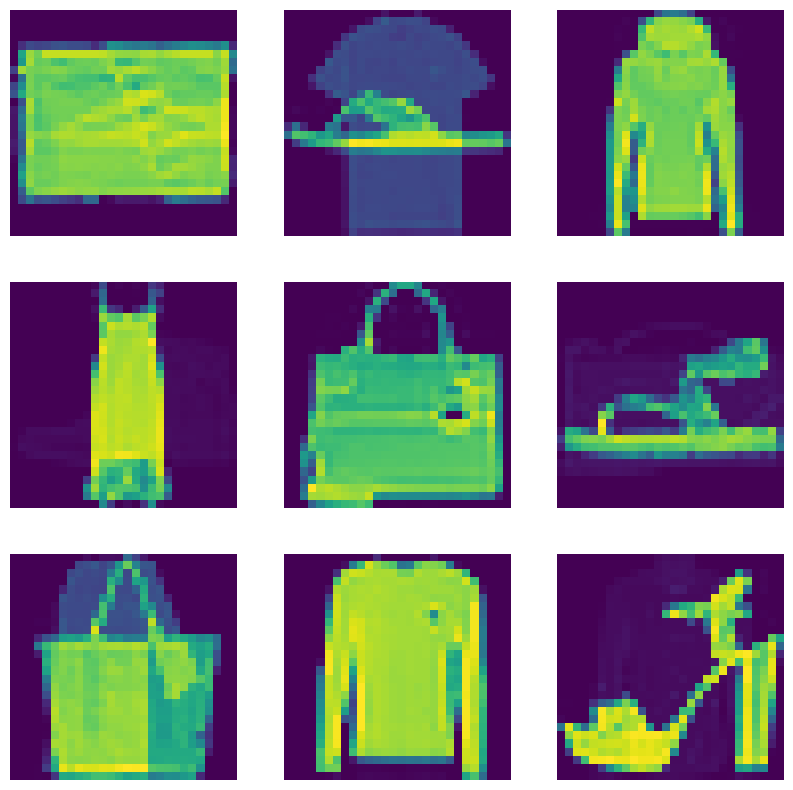

In [24]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=AUTO,
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

## Model building

In [33]:

def get_training_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model


For the sake of reproducibility, we serialize the initial random weights of our shallow
network.

In [34]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.weights.h5")

## 1. Train the model with the mixed up dataset

In [35]:
model = get_training_model()
model.load_weights("initial_weights.weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 11s 6ms/step - loss: 1.1732 - accuracy: 0.6357 - val_loss: 0.6645 - val_accuracy: 0.7560
Epoch 2/10
907/907 [==============================] - 4s 4ms/step - loss: 0.9370 - accuracy: 0.7303 - val_loss: 0.5845 - val_accuracy: 0.7900
Epoch 3/10
907/907 [==============================] - 5s 5ms/step - loss: 0.8564 - accuracy: 0.7644 - val_loss: 0.5101 - val_accuracy: 0.8240
Epoch 4/10
907/907 [==============================] - 4s 5ms/step - loss: 0.8107 - accuracy: 0.7865 - val_loss: 0.4573 - val_accuracy: 0.8445
Epoch 5/10
907/907 [==============================] - 4s 5ms/step - loss: 0.7743 - accuracy: 0.8021 - val_loss: 0.4182 - val_accuracy: 0.8590
Epoch 6/10
907/907 [==============================] - 5s 5ms/step - loss: 0.7497 - accuracy: 0.8116 - val_loss: 0.4030 - val_accuracy: 0.8620
Epoch 7/10
907/907 [==============================] - 4s 5ms/step - loss: 0.7294 - accuracy: 0.8201 - val_loss: 0.3874 - val_accuracy: 0.8650
Epoch

## 2. Train the model *without* the mixed up dataset

In [36]:
model = get_training_model()
model.load_weights("initial_weights.weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 6s 5ms/step - loss: 0.8644 - accuracy: 0.6736 - val_loss: 0.6227 - val_accuracy: 0.7655
Epoch 2/10
907/907 [==============================] - 4s 4ms/step - loss: 0.6109 - accuracy: 0.7708 - val_loss: 0.5450 - val_accuracy: 0.8025
Epoch 3/10
907/907 [==============================] - 4s 4ms/step - loss: 0.5420 - accuracy: 0.8017 - val_loss: 0.4718 - val_accuracy: 0.8380
Epoch 4/10
907/907 [==============================] - 5s 5ms/step - loss: 0.4944 - accuracy: 0.8204 - val_loss: 0.4486 - val_accuracy: 0.8450
Epoch 5/10
907/907 [==============================] - 4s 4ms/step - loss: 0.4591 - accuracy: 0.8331 - val_loss: 0.4089 - val_accuracy: 0.8595
Epoch 6/10
907/907 [==============================] - 4s 4ms/step - loss: 0.4296 - accuracy: 0.8439 - val_loss: 0.3826 - val_accuracy: 0.8705
Epoch 7/10
907/907 [==============================] - 5s 5ms/step - loss: 0.4047 - accuracy: 0.8547 - val_loss: 0.3663 - val_accuracy: 0.8750
Epoch 

Readers are encouraged to try out mixup on different datasets from different domains and
experiment with the lambda parameter. You are strongly advised to check out the
[original paper](https://arxiv.org/abs/1710.09412) as well - the authors present several ablation studies on mixup
showing how it can improve generalization, as well as show their results of combining
more than two images to create a single one.

## Notes

* With mixup, you can create synthetic examples — especially when you lack a large
dataset - without incurring high computational costs.
* [Label smoothing](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/) and mixup usually do not work well together because label smoothing
already modifies the hard labels by some factor.
* mixup does not work well when you are using [Supervised Contrastive
Learning](https://arxiv.org/abs/2004.11362) (SCL) since SCL expects the true labels
during its pre-training phase.
* A few other benefits of mixup include (as described in the [paper](https://arxiv.org/abs/1710.09412)) robustness to
adversarial examples and stabilized GAN (Generative Adversarial Networks) training.
* There are a number of data augmentation techniques that extend mixup such as
[CutMix](https://arxiv.org/abs/1905.04899) and [AugMix](https://arxiv.org/abs/1912.02781).